# Setup

In [ ]:
!nvidia-smi

Wed Mar 17 21:01:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U watermark
!pip install -qq transformers
!pip install transformers==3

%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

     |████████████████████████████████| 2.1MB 12.4MB/s 
     |████████████████████████████████| 890kB 51.1MB/s 
     |████████████████████████████████| 3.2MB 58.1MB/s 
     |████████████████████████████████| 757kB 14.9MB/s 
     |████████████████████████████████| 3.0MB 37.1MB/s 
     |████████████████████████████████| 1.2MB 54.7MB/s 
  Found existing installation: tokenizers 0.10.1
    Uninstalling tokenizers-0.10.1:
      Successfully uninstalled tokenizers-0.10.1
  Found existing installation: transformers 4.4.1
    Uninstalling transformers-4.4.1:
      Successfully uninstalled transformers-4.4.1
Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.0+cu101
transformers: 3.0.0



device(type='cuda', index=0)

# Data Exploration

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving training_set_cln.csv to training_set_cln.csv


In [ ]:
import io
df_raw = pd.read_csv(io.BytesIO(uploaded['training_set_cln.csv']))
df_raw = df_raw[['rating', 'content']]

print('The length of training set: ' + str(df_raw.shape[0]))
df_raw.head()

The length of training set: 35571


,rating,content
0,5,Very adaptable to all different location mounts.
1,2,I thought it was a speaker but it's just a lit...
2,1,Miss leading add it's not useful\nfor anything
3,1,"never use it,but check it out,in half month so..."
4,5,Fits perfect in my Callaway Golf Bag


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


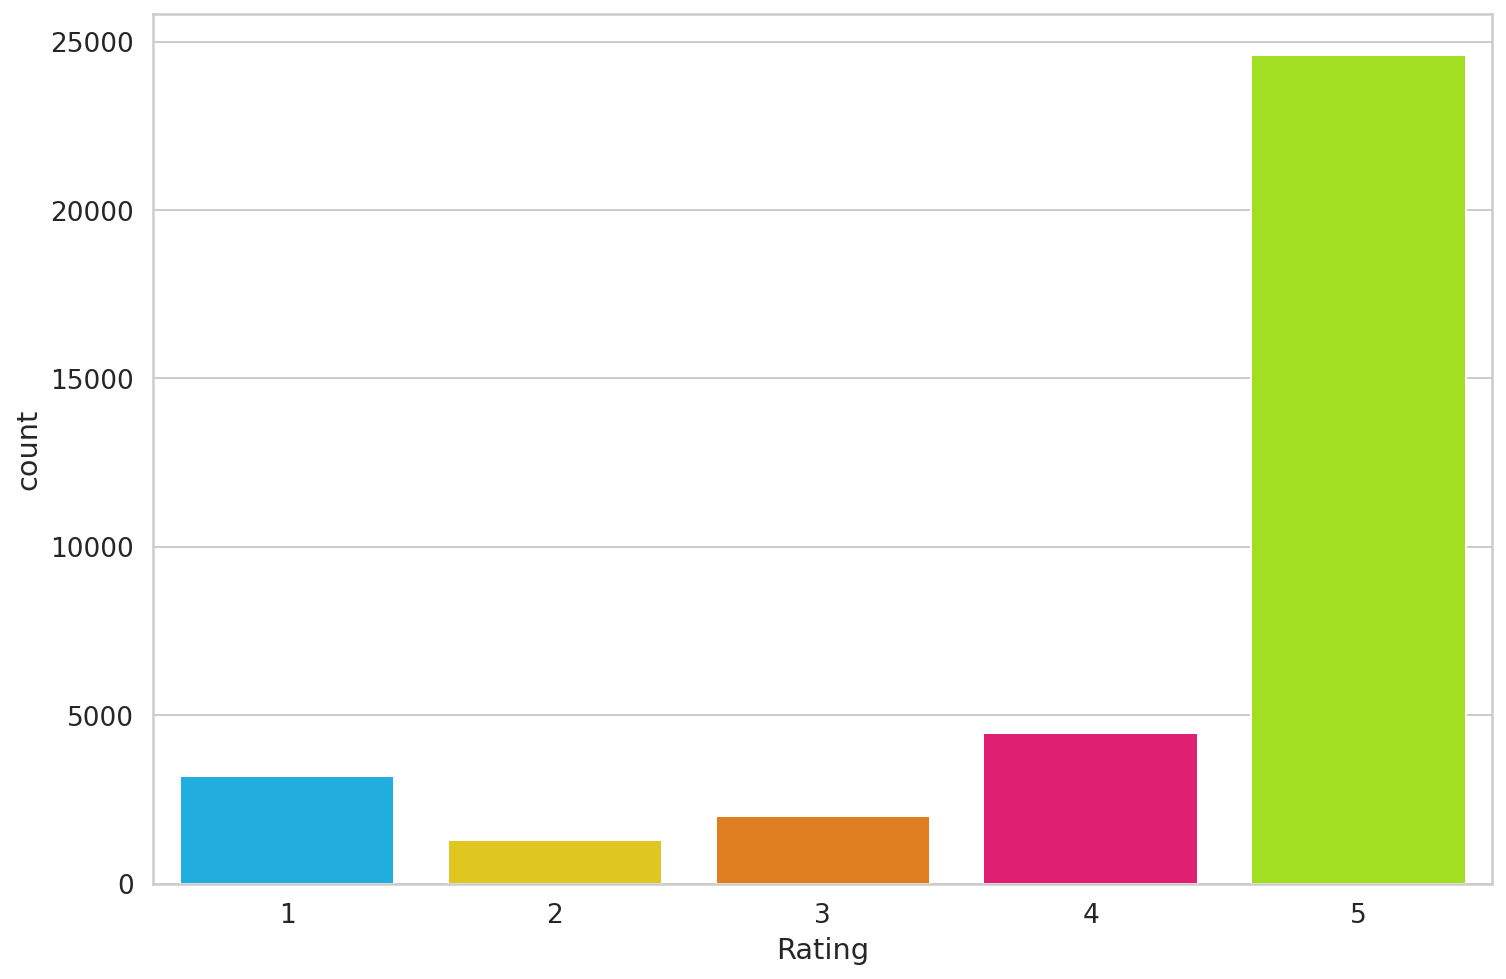

In [ ]:
# The distribution of training set
sns.countplot(df_raw.rating)
plt.xlabel('Rating');

In [ ]:
df = df_raw[df_raw['rating'] != 3]

# Define Sentiment Classes

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  else: 
    return 1

df['sentiment'] = df.rating.apply(to_sentiment)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


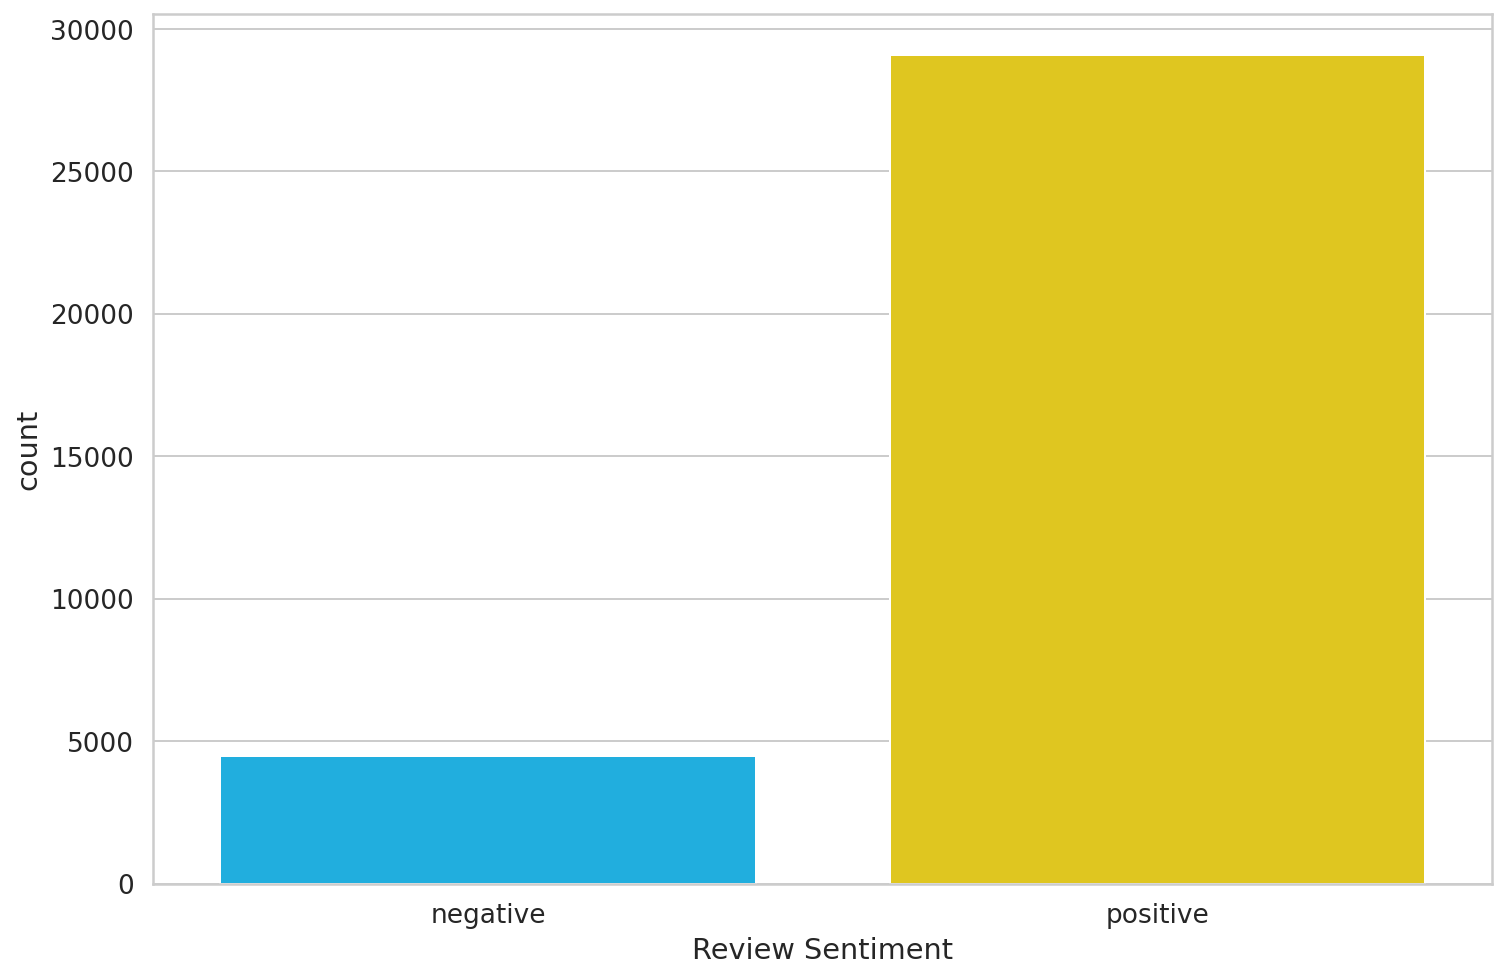

In [ ]:
class_names = ['negative', 'positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('Review Sentiment')
ax.set_xticklabels(class_names);

# Data Preprocessing

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'Very adaptable to all different location mounts.'

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

### Choosing Sequence Length

In [ ]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


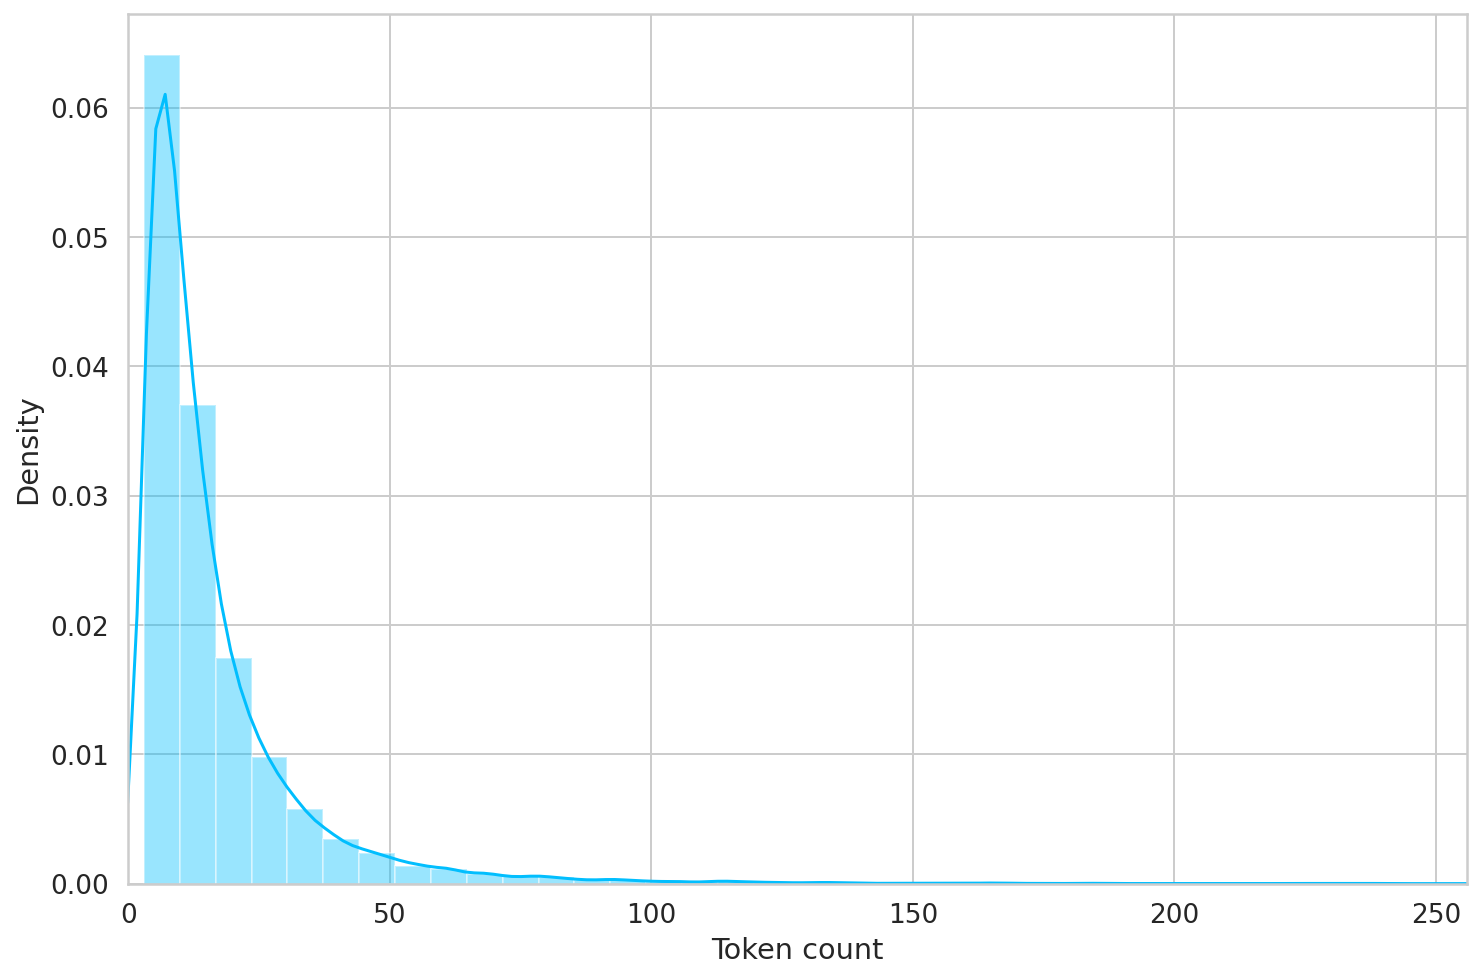

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 150

### Create Training, Validation, and Testing Datasets

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):  
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train_raw, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train_raw.shape, df_val.shape, df_test.shape

((30205, 3), (1678, 3), (1679, 3))

### Create Balanced Training Set

In [ ]:
df_tr1 = df_train_raw[df_train_raw['rating'] <= 2]
df_tr2 = df_train_raw[df_train_raw['rating'] >= 4]

print(df_tr1.rating.count())
print(df_tr2.rating.count())

4003
26202


In [ ]:
df_tr1_os = df_tr1.sample(df_tr2.shape[0], replace=True)
df_tr2_os = df_tr2


print(df_tr1_os.rating.count())
print(df_tr2_os.rating.count())

df_train = pd.concat([df_tr1_os, df_tr2_os])

26202
26202


### Create Data Loader

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    shuffle=True,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader,))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


# Sentiment Classification with BERT

### Setup

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(input_ids=encoding['input_ids'], 
                                              attention_mask=encoding['attention_mask'])

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 150])
torch.Size([16, 150])


In [ ]:
model(input_ids, attention_mask)

tensor([[-0.5676, -0.0608],
        [-0.2693, -0.0733],
        [-0.0761,  0.0010],
        [-0.1112,  0.2624],
        [-0.4874, -0.1455],
        [-0.1859, -0.0371],
        [-0.0629, -0.4174],
        [-0.1861, -0.0943],
        [-0.4568, -0.1186],
        [-0.3173, -0.3869],
        [-0.6276, -0.2110],
        [ 0.1798, -0.4233],
        [-0.1227,  0.0571],
        [-0.8575, -0.0167],
        [-0.9564, -0.5388],
        [-0.5125, -0.4553]], device='cuda:0', grad_fn=<AddmmBackward>)

### Training

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.1490767406774753 accuracy 0.957674986642241
Val   loss 0.11639356289413713 accuracy 0.9642431466030988

Epoch 2/10
----------
Train loss 0.06334151824837765 accuracy 0.9865277459735898
Val   loss 0.14098780214886314 accuracy 0.971394517282479

Epoch 3/10
----------
Train loss 0.03766585990632114 accuracy 0.9920044271429662
Val   loss 0.20593835118557935 accuracy 0.9612634088200238

Epoch 4/10
----------
Train loss 0.022629042555138937 accuracy 0.995286619342035
Val   loss 0.20261086944900897 accuracy 0.9630512514898688

Epoch 5/10
----------
Train loss 0.0157703853595242 accuracy 0.996431570109152
Val   loss 0.26431287363668077 accuracy 0.9648390941597139

Epoch 6/10
----------
Train loss 0.01333785981919041 accuracy 0.9970994580566369
Val   loss 0.2600052675554512 accuracy 0.9654350417163289

Epoch 7/10
----------
Train loss 0.010127583964248392 accuracy 0.997710098465766
Val   loss 0.3205174771238186 accuracy 0.9636471990464839

Epoch 8/10
---------

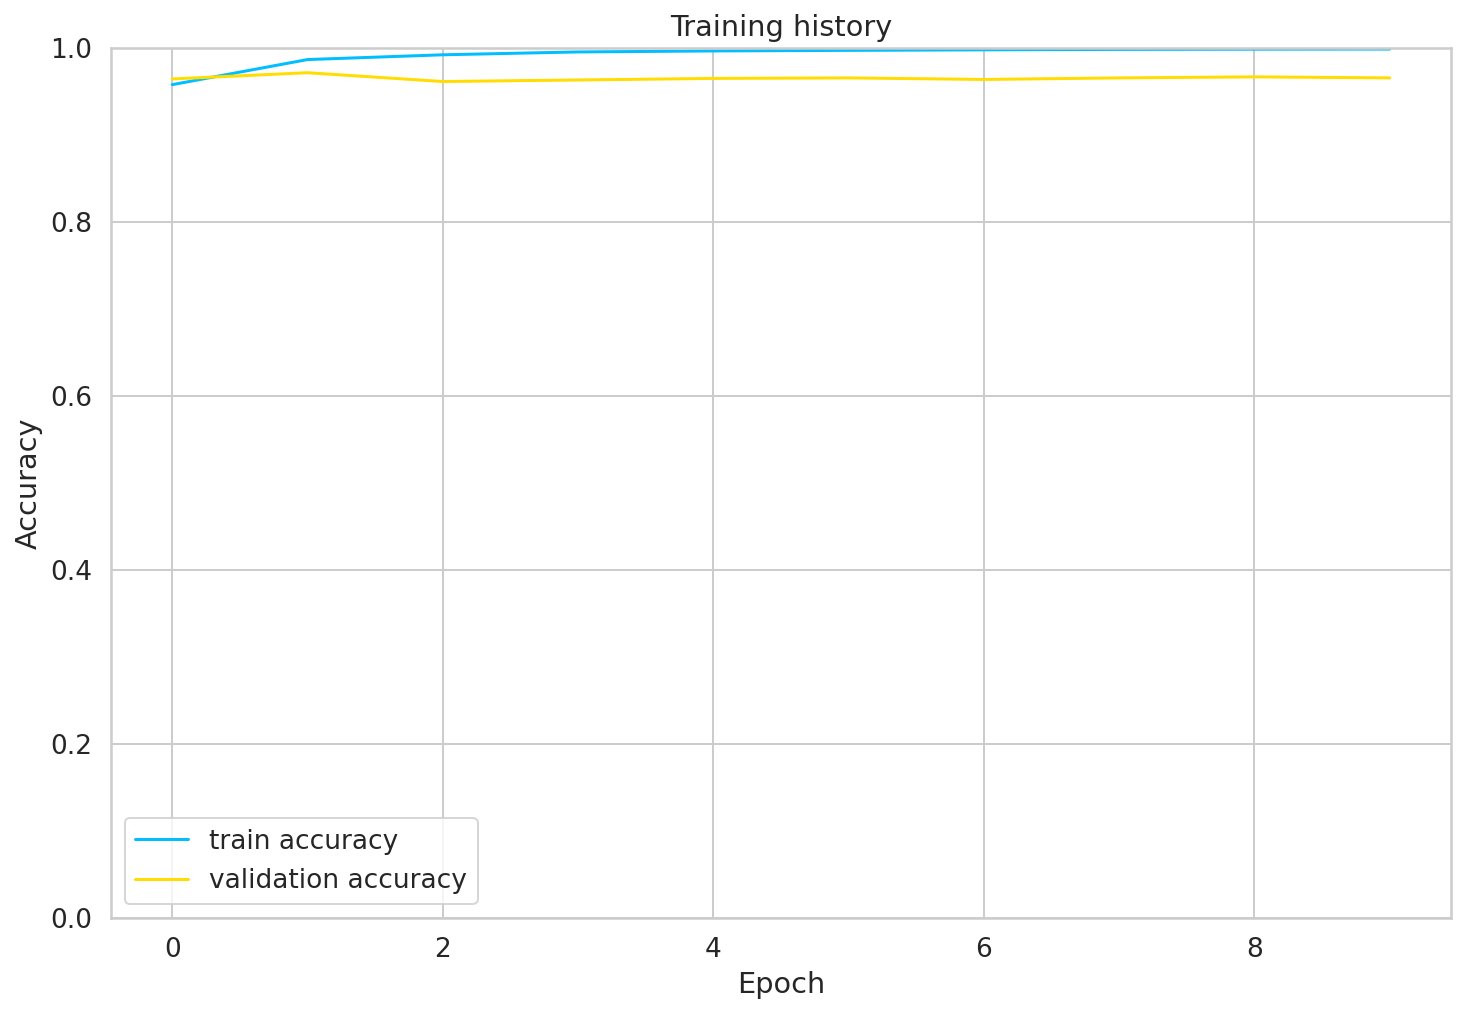

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9618820726622991

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, 
                                                               test_data_loader)

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.87      0.88      0.87       248
    positive       0.98      0.98      0.98      1431

    accuracy                           0.96      1679
   macro avg       0.92      0.93      0.92      1679
weighted avg       0.96      0.96      0.96      1679



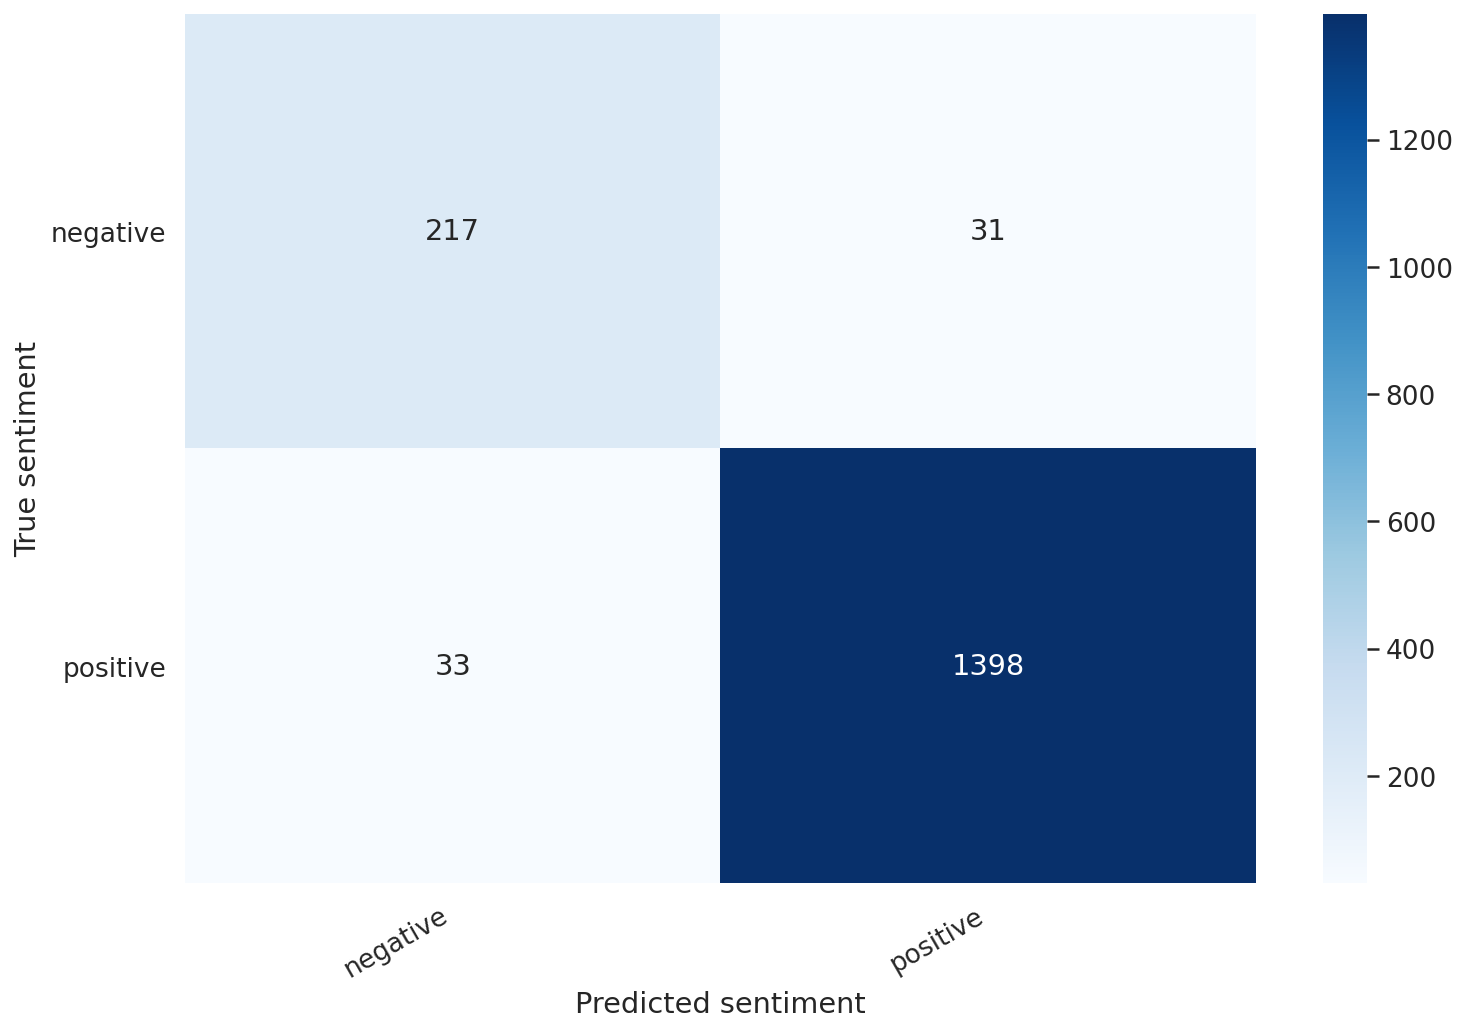

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Testing with Randam Data

My daughter takes it every where she goes

True sentiment: positive


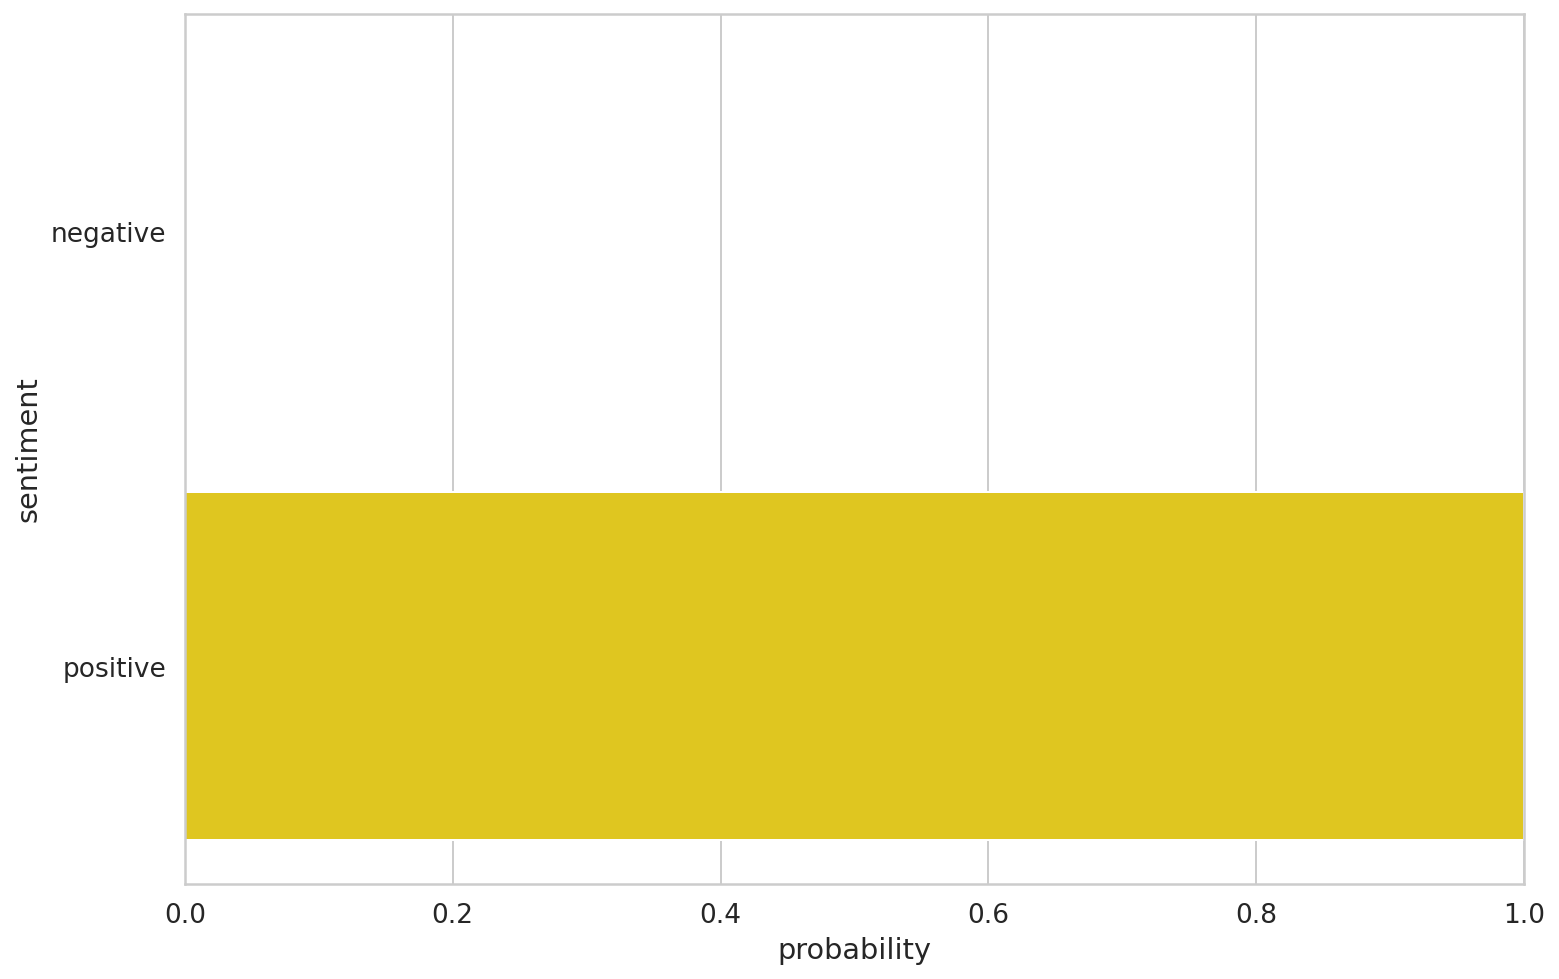

In [ ]:
import random

idx = random.randint(0, len(y_review_texts))

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Testing with Data from Other Data Set

In [ ]:
review_text = "I like the way you think"

encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

prob = F.softmax(output, dim=1)

print(f'Review text : {review_text}')
print(f'Sentiment   : {class_names[prediction]}')
print('probability : ' + str(prob))

Review text : I like the way you think
Sentiment   : positive
probability : tensor([[4.4904e-06, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>)


# Saving and Loading

### Save SA Model

In [ ]:
device = torch.device('cuda')
model.to(device)
torch.save(model.state_dict(), 'SA_Model_v7_2cls_os_shuffle.pt')

### Load SA Model

In [ ]:
# Load on CPU

# device = torch.device("cpu")
# model = Model(*args, **kwargs)
# model.load_state_dict(torch.load('SA Model_v4.pt', map_location=device))

In [ ]:
# Load on GPU

# model = Model(*args, **kwargs)
# model.load_state_dict(torch.load('SA Model_v4.pt'))
# model.to(device)

### Reference

This notebook refers to an online tutorial for test classification created by Venelin Valkov in the following link:

https://www.youtube.com/watch?v=8N-nM3QW7O0